###### Imports & Data loading

In [1]:
import pandas as pd
from pulp import LpProblem, LpVariable, lpSum, LpMinimize, LpAffineExpression, \
LpConstraint, PULP_CBC_CMD
import numpy as np
import pulp as plp
import seaborn as sns
from notebooks_module.linear_programming import CorrelationCutoff,\
formulateMP, checkFeasibility, infeasibilitySearch

In [98]:
import importlib
import notebooks_module.linear_programming

In [99]:
importlib.reload(notebooks_module.linear_programming)

<module 'notebooks_module.linear_programming' from '/Users/williammohr/DataScience/portfolio/Nutrition/03_Notebooks/notebooks_module/linear_programming.py'>

In [2]:
foods = pd.read_csv('../02_Data_formatted/nv_df.csv', index_col='Unnamed: 0')
constraints = pd.read_csv('../02_Data_formatted/constraints.csv', 
index_col = 'Unnamed: 0')

In [3]:
# identify amino acids
amino_acids = CorrelationCutoff(foods.corr()['phenylalanine_tyrosine'],.9)
amino_acids = [aa for aa in amino_acids if aa != 'protein']
# curate the constraints list: chloride provided by salt, 
# cholesterol guidelines are particular to each person,
# vitamin b12 is easily and safely supplemented
constraints.drop(index = [
    # 'fat_total','carbohydrates','protein',  'calories',
    'cholesterol','chloride','vitamin_b12'], inplace = True)

In [4]:
# Adjust amino acid requirements for bodyweight
usr_mass = input("How many kilos do you weigh?")
usr_mass = int(usr_mass)
constraints.loc[amino_acids,'min'] *= usr_mass

How many kilos do you weigh? 77


In [5]:
# categorize constraints for exclusions from mathematical model
spices = foods[foods.calories<=15]
foods_substantial = foods.loc[[food for food in foods.index.values if 
                   food not in spices.index],:]

In [6]:
# Adjust constraint values
constraints.loc['fat_total','min']=0
# constraints.loc['protein','min']=0
constraints.loc['chloride','max']=3100
constraints.loc['biotin','min'] = 40
constraints.loc['sodium','min'] = 0
constraints.loc['calories','min']=0
constraints.loc['carbohydrates','min']=0
constraints.loc['calcium','min']=0


In [7]:
servings_contraints = pd.DataFrame(columns = ['min','max'], index = foods.index)
servings_contraints.loc[:,['min','max']] = [0,3]

In [8]:
# servings_contraints.loc['broccoli_chopped_cooked','min'] = 1
# servings_contraints.loc['cauliflower_cooked','min'] = 1
# servings_contraints.loc['carrots_sliced_raw','min'] = 1
# servings_contraints.loc['mushrooms_shiitake_cooked','min'] = 1
# servings_contraints.loc['olive_oil_cold_pressed_extra_virgin','min'] = 1
# servings_contraints.loc['olives_black_canned','min'] = 1
servings_contraints.loc['blueberries_fresh','min'] = 0
# servings_contraints.loc['oranges_fresh','min'] = 1
# servings_contraints.loc['garbanzo_beans_cooked','min'] = 1
# servings_contraints.loc['tempeh_cooked','min'] = 1
servings_contraints.loc['kale_cooked','min'] = 2.5
# servings_contraints.loc['eggs_pasture_raised_large_hard_boiled','min'] = 2
# servings_contraints.loc['salmon_wild_coho_broiled','min'] = 1
# servings_contraints.loc['bell_peppers_sliced_red_raw','min'] = 1

In [9]:
lp_formulation = formulateMP(foods,constraints,servings_contraints,integer=False)
lp_formulation.solve()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/williammohr/opt/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/7q/63cgxnn50sl5zwxkchv_j2cr0000gn/T/392c61e2e5154c29b6db33ae27cf1b58-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/7q/63cgxnn50sl5zwxkchv_j2cr0000gn/T/392c61e2e5154c29b6db33ae27cf1b58-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 64 COLUMNS
At line 6116 RHS
At line 6176 BOUNDS
At line 6295 ENDATA
Problem MODEL has 59 rows, 117 columns and 5934 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 49 (-10) rows, 117 (0) columns and 4854 (-1080) elements
0  Obj 91 Primal inf 1021.6652 (29)
19  Obj 696.16444
Optimal - objective value 696.16444
After Postsolve, objective 696.16444, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 696.1644378 - 19 iterations time 0.002, Presolv

1

###### What do the loadings look like for the solution with the infeasible constraints removed?

In [10]:
total_cals = 0
food_servings = {}
for v in lp_formulation.variables():
    total_cals += v.varValue*foods.at[v.name,'calories']
    food_servings[v.name] = v.varValue
food_servings[v.name] = v.varValue
food_srv_dict = {food:srv for food, srv in food_servings.items() if srv != 0}

In [11]:
food_srv_dict

{'asparagus_cooked': 1.6596046,
 'basil_chopped_fresh': 0.99731025,
 'beef_grass_fed_strip_steak_cooked': 0.26142516,
 'broccoli_chopped_cooked': 1.6645711,
 'cucumber_sliced_raw': 2.8694395,
 'eggs_pasture_raised_large_hard_boiled': 1.7110324,
 'kale_cooked': 2.5,
 'mushrooms_crimini_raw': 3.0,
 'mushrooms_shiitake_cooked': 1.1675052,
 'salmon_wild_coho_broiled': 0.18051809,
 'tomatoes_sliced_raw': 3.0}

###### Investigating failed constraints

In [12]:
nutrient_total = pd.Series(data = [0]*foods.shape[1], index = foods.columns)
for food, srv in food_srv_dict.items():
    foods.loc[food,:]
    nutrient_total += foods.loc[food,:]*srv
nutrient_total

calories                   696.164441
protein                     56.000000
fat_total                   17.062394
saturated_fat                4.613159
cholesterol                312.924721
sodium                     407.461687
choline                    604.169991
folate                    1000.000011
niacin                      33.323849
pantothenic_acid            11.558756
vitamin_b2                   2.852651
vitamin_b1                   1.457087
vitamin_a                 3000.000003
vitamin_b12                  2.551058
vitamin_b6                   2.554807
vitamin_c                  411.456967
vitamin_d_mcg                5.000000
vitamin_k                 3352.671444
calcium                    641.813706
copper                       3.580245
iron                        13.275862
magnesium                  320.000002
manganese                    3.911431
phosphorus                1199.004551
potassium                 5316.577143
selenium                   143.794322
zinc        

In [13]:
nutrient_total/constraints['max']

biotin                         NaN
calcium                   0.256725
calories                  0.348082
carbohydrates             0.260161
chloride                  0.273938
cholesterol                    NaN
choline                   0.172620
chromium                       NaN
copper                    0.358025
cysteine_methionine            NaN
fat_total                 0.218749
fiber                          NaN
folate                    1.000000
histidine                      NaN
iron                      0.331897
leucine                        NaN
lysine                         NaN
magnesium                      NaN
manganese                 0.355585
methionine                     NaN
molybdenum                0.028581
niacin                    0.952110
pantothenic_acid               NaN
phenylalanine_tyrosine         NaN
phosphorus                0.299751
potassium                      NaN
protein                   0.350000
saturated_fat             0.384430
selenium            

In [14]:
nutrient_total/constraints['min']

biotin                     1.000000
calcium                         inf
calories                        inf
carbohydrates                   inf
chloride                        NaN
cholesterol                     NaN
choline                    1.098491
chromium                   1.000000
copper                     3.978050
cysteine_methionine        1.256768
fat_total                       inf
fiber                      1.157961
folate                     2.500000
histidine                  1.259027
iron                       1.659483
leucine                    1.150726
lysine                     1.267603
magnesium                  1.000000
manganese                  1.700622
methionine                 1.092960
molybdenum                 1.681225
niacin                     2.082741
pantothenic_acid           2.311751
phenylalanine_tyrosine     1.591107
phosphorus                 1.712864
potassium                  1.131187
protein                    1.000000
saturated_fat               

###### Plot contribution breakdown by food type for each nutrient

In [15]:
pd.DataFrame.from_dict({food:foods.at[food,'protein']*srv for food, srv in food_srv_dict.items()},orient ='index',columns=['grams_protein'] )

,grams_protein
asparagus_cooked,7.169492
basil_chopped_fresh,0.668198
beef_grass_fed_strip_steak_cooked,6.838882
broccoli_chopped_cooked,6.175559
cucumber_sliced_raw,1.951219
eggs_pasture_raised_large_hard_boiled,10.762394
kale_cooked,6.175000
mushrooms_crimini_raw,5.400000
mushrooms_shiitake_cooked,1.319281
salmon_wild_coho_broiled,4.799976


In [16]:
food_srv_dict

{'asparagus_cooked': 1.6596046,
 'basil_chopped_fresh': 0.99731025,
 'beef_grass_fed_strip_steak_cooked': 0.26142516,
 'broccoli_chopped_cooked': 1.6645711,
 'cucumber_sliced_raw': 2.8694395,
 'eggs_pasture_raised_large_hard_boiled': 1.7110324,
 'kale_cooked': 2.5,
 'mushrooms_crimini_raw': 3.0,
 'mushrooms_shiitake_cooked': 1.1675052,
 'salmon_wild_coho_broiled': 0.18051809,
 'tomatoes_sliced_raw': 3.0}

why so much calcium

In [17]:
import matplotlib.pyplot as plt

In [29]:
constraint_cols = 3
if constraints.shape[0]%cols != 0:
    rows = constraints.shape[0]//cols
else:
    constraint_rows = constraints.shape[0]//cols + 1
plots_range = range(1,constraints.shape[0])

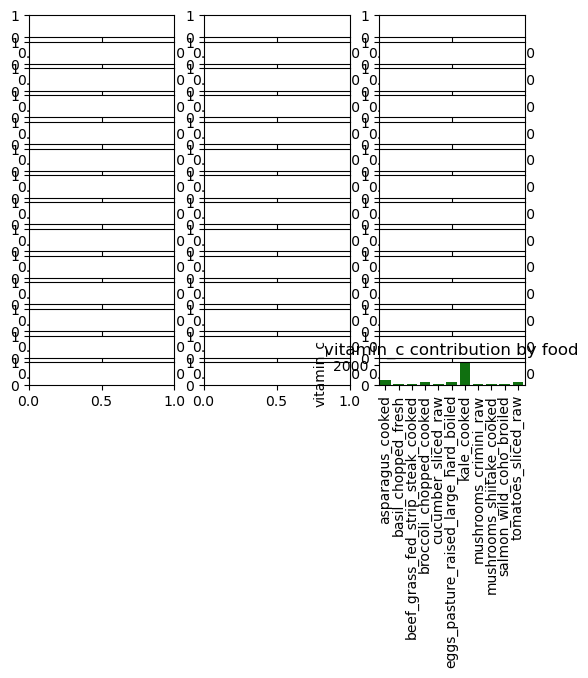

In [37]:
fig, axs = plt.subplots(nrows=constraint_rows, ncols=constraint_cols)
for n, ax in enumerate(axs):
    makePlot(ax, nutrient= constraints.index[n])

In [34]:
axs.shape

(14, 3)

In [18]:
def makePlot(ax, fd_srv_dict = food_srv_dict, nutrient='protein',foods=foods):
    '''make a plot to show the nutrient contribution for each of the foods'''
    nutrient_df = pd.DataFrame.from_dict(
        {food:foods.at[food,f'{nutrient}']*srv for food, srv in 
         food_srv_dict.items()}, orient ='index', columns=[f'{nutrient}'] )
    ax.barplot(x = nutrient_df.index,y=nutrient_df[f'{nutrient}'],
               color='g').set(title=f'{nutrient} contribution by food')
    plt.xticks(rotation=90)

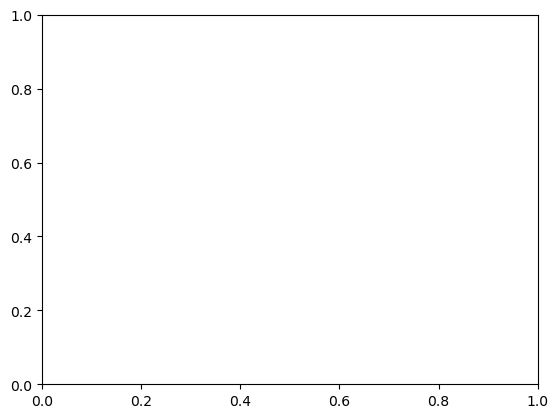

In [42]:
fig = plt.figure(1)
ax = fig.add_subplot()
ax.bar(range(len(fd_srv_dict)),food_srv_dict[],)

In [84]:
a = [[1,2,3],[4,5,6],7]

In [85]:
b = a[:]

In [91]:
b[0].remove(2)

In [ ]:
ro

In [93]:
a

[[1, 3], [4, 5, 6], 7]

In [80]:
del(b[len(b):])

In [81]:
b

[[3, 4]]

In [69]:
b = [[1,2],[3,4]]

In [76]:
c = b[-10:4]

In [77]:
c

[[1, 2], [3, 4]]

In [65]:
b[0] = [3,6]

In [66]:
c

[[2, 4], [3, 4]]

In [48]:
a = [1,2,3]

In [54]:
a[len(a)+10:]=[1]

In [55]:
a

[1, 2, 3, 1]

In [47]:
food_srv_dict.items()

dict_items([('asparagus_cooked', 1.6596046), ('basil_chopped_fresh', 0.99731025), ('beef_grass_fed_strip_steak_cooked', 0.26142516), ('broccoli_chopped_cooked', 1.6645711), ('cucumber_sliced_raw', 2.8694395), ('eggs_pasture_raised_large_hard_boiled', 1.7110324), ('kale_cooked', 2.5), ('mushrooms_crimini_raw', 3.0), ('mushrooms_shiitake_cooked', 1.1675052), ('salmon_wild_coho_broiled', 0.18051809), ('tomatoes_sliced_raw', 3.0)])

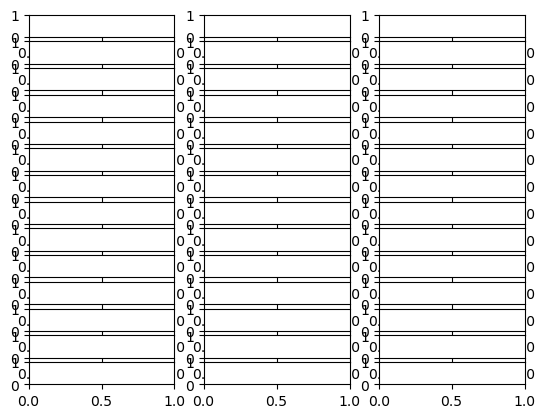

In [ ]:
def my_plotter(ax, data1, data2, param_dict):
    """
    A helper function to make a graph.
    """
    out = ax.plot(data1, data2, **param_dict)
    return out

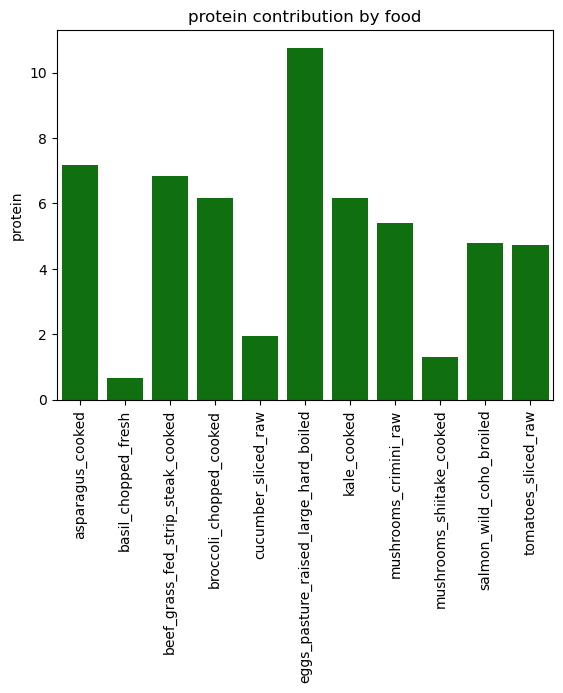

In [19]:
makePlot()

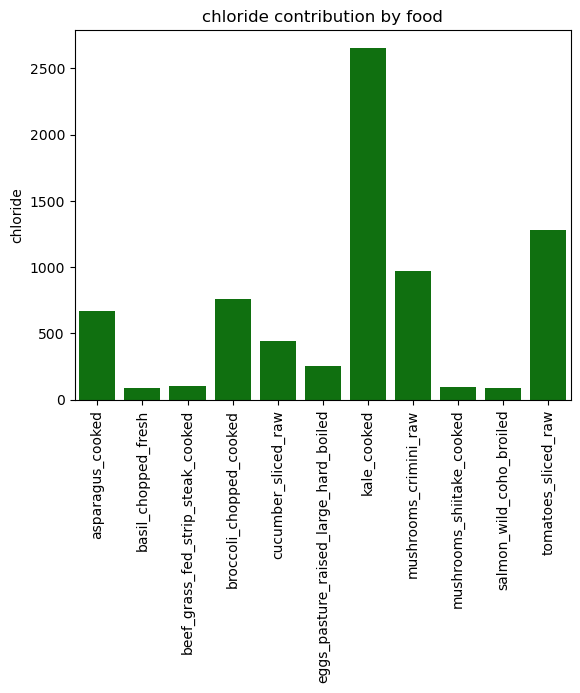

In [23]:
fig = plt.figure(1)
for k in range(constraints.shape[0]):
    ax = fig.add_subplot(k)
    ax.plot
    
    